In [1]:
from bnn.data import category_examples
from bnn.util import open_pickle_file
from bnn.predict import predict_on_data

from keras import backend as K
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import math
from tensorflow.contrib import distributions
from scipy.misc import logsumexp

Using TensorFlow backend.


In [2]:
# Bayesian categorical cross entropy.
# N data points, C classes, T monte carlo simulations
# true - true values. Shape: (N, C)
# pred_var - predicted logit values and variance. Shape: (N, C + 1)
# returns - loss (N, C)
def bayesian_categorical_crossentropy(T, num_classes):
  def bayesian_categorical_crossentropy_internal(true, pred_var):
    # shape: [N, 1]
    std_vals = K.sqrt(pred_var[:, num_classes:])
    # shape: [N, C]
    std = true * std_vals
    pred = pred_var[:, 0:num_classes]
    iterable = K.variable(np.ones(T))
    dist = distributions.Normal(loc=K.zeros_like(std), scale=std)
    monte_carlo_results = K.map_fn(gaussian_categorical_crossentropy(true, pred, dist), iterable, name='monte_carlo_results')
    return K.mean(monte_carlo_results, axis=0)
  return bayesian_categorical_crossentropy_internal

# for a single monte carlo simulation, 
#   calculate categorical_crossentropy of 
#   predicted logit values plus gaussian 
#   noise vs true values.
# true - true values. Shape: (N, C)
# pred - predicted logit values. Shape: (N, C)
# dist - normal distribution to sample from. Shape: (N)
# returns - total differences for all classes (N)
def gaussian_categorical_crossentropy(true, pred, dist):
  def map_fn(i):
    return K.categorical_crossentropy(pred + dist.sample(1), true, from_logits=True)
  return map_fn

In [3]:
def loss_matrix(min_x=-4, max_x=4, min_y=0, max_y=100):
  loss_fn = bayesian_categorical_crossentropy(10000, 2)

  correct_val = 1.0
#   third_val = 0.0

  X = [1.0 + x/2 for x in range(min_x, max_x+1)]
  Y = [0.000000001 + y/50 for y in range(min_y, max_y+1)]
  X, Y = np.meshgrid(X, Y)
  predictions = []

  for i in range(len(X)):
    for j in range(len(X[0])):
      y = Y[i][j]
      x = X[i][j]
      predictions.append([correct_val, x, y])

  pred_count = len(predictions)
  true = K.variable(np.hstack((np.ones((pred_count, 1)), np.zeros((pred_count, 1)), )))
  pred_var = K.variable(np.array(predictions))
  Z = K.eval(loss_fn(true, pred_var))
  Z = np.reshape(Z, (len(X), len(X[0])))
  return (X, Y, Z)

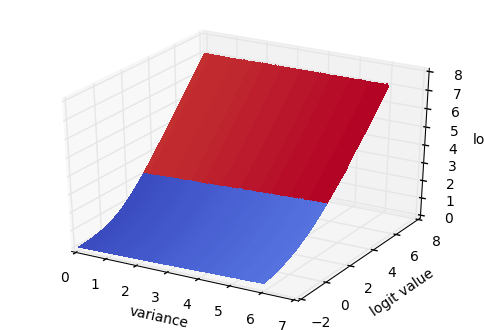

In [4]:
from mpl_toolkits.mplot3d import Axes3D
X, Y, Z = loss_matrix(min_x=-6, max_x=14, max_y=300)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Y, X, Z, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('variance')
ax.set_ylabel('logit value')
ax.set_zlabel('loss')
plt.show()

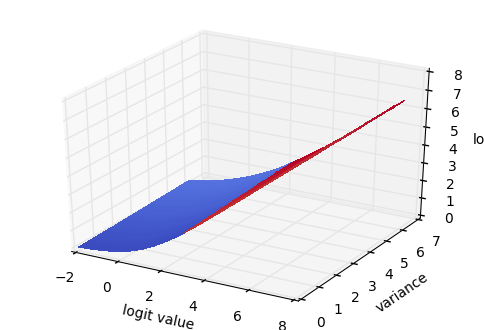

In [5]:
from mpl_toolkits.mplot3d import Axes3D
X, Y, Z = loss_matrix(min_x=-6, max_x=14, max_y=300)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('logit value')
ax.set_ylabel('variance')
ax.set_zlabel('loss')
plt.show()

In [6]:
print("Max variance:")
for i in range(len(X[0])):
    print('  logit value:', X[-1,i], 'variance:', Y[-1,i], 'loss:', Z[-1,i])
print("Min variance:")
for i in range(len(X[0])):
    print('  logit value:', X[0,i], 'variance:', Y[0,i], 'loss:', Z[0,i])
print("Max logit value:")
for i in range(int(len(X)/5)):
    print('  logit value:', X[i*5,-1], 'variance:', Y[i*5,-1], 'loss:', Z[i*5,-1])
print("Min logit value:")
for i in range(int(len(X)/5)):
    print('  logit value:', X[i*5,0], 'variance:', Y[i*5,0], 'loss:', Z[i*5,0])
print("0 logit difference")
for i in range(int(len(X)/5)):
  mid = int(len(X[0])/2) -1
  print('  logit value:', X[i*5,mid], 'variance:', Y[i*5,mid], 'loss:', Z[i*5,mid])   
    

Max variance:
  logit value: -2.0 variance: 6.000000001 loss: 0.257599
  logit value: -1.5 variance: 6.000000001 loss: 0.356234
  logit value: -1.0 variance: 6.000000001 loss: 0.461815
  logit value: -0.5 variance: 6.000000001 loss: 0.61443
  logit value: 0.0 variance: 6.000000001 loss: 0.787641
  logit value: 0.5 variance: 6.000000001 loss: 0.986182
  logit value: 1.0 variance: 6.000000001 loss: 1.21548
  logit value: 1.5 variance: 6.000000001 loss: 1.47125
  logit value: 2.0 variance: 6.000000001 loss: 1.76676
  logit value: 2.5 variance: 6.000000001 loss: 2.09325
  logit value: 3.0 variance: 6.000000001 loss: 2.48343
  logit value: 3.5 variance: 6.000000001 loss: 2.86009
  logit value: 4.0 variance: 6.000000001 loss: 3.29261
  logit value: 4.5 variance: 6.000000001 loss: 3.68773
  logit value: 5.0 variance: 6.000000001 loss: 4.14571
  logit value: 5.5 variance: 6.000000001 loss: 4.56729
  logit value: 6.0 variance: 6.000000001 loss: 5.06346
  logit value: 6.5 variance: 6.000000001 l

In [7]:
print("Size:", X.shape)
print("Max variance. min idx:", np.argmin(Z[-1,:]), "logit that minimizes loss:", X[-1, np.argmin(Z[-1,:])])
print("Min variance. min idx", np.argmin(Z[0,:]), "logit that minimizes loss:", X[0,np.argmin(Z[0,:])])
print("Max logit value. min idx:", np.argmin(Z[:,-1]), "variance that minimizes loss:", Y[np.argmin(Z[:,-1]), -1])
print("Min logit. min idx:", np.argmin(Z[:,0]), "varaince that minimizes loss:", Y[np.argmin(Z[:,0]), 0])

Size: (301, 21)
Max variance. min idx: 0 logit that minimizes loss: -2.0
Min variance. min idx 0 logit that minimizes loss: -2.0
Max logit value. min idx: 266 variance that minimizes loss: 5.320000001
Min logit. min idx: 0 varaince that minimizes loss: 1e-09


In [8]:
for i in range(len(X[0])):
  min_var_idx = np.argmin(Z[:,i])
  print('idx:', i, 'logit value:', X[0,i], 'variance:', Y[min_var_idx,i], 'loss:', Z[min_var_idx,i], "fc'-fc:", X[0,i]-1.0)

idx: 0 logit value: -2.0 variance: 1e-09 loss: 0.0485848 fc'-fc: -3.0
idx: 1 logit value: -1.5 variance: 1e-09 loss: 0.078894 fc'-fc: -2.5
idx: 2 logit value: -1.0 variance: 1e-09 loss: 0.12694 fc'-fc: -2.0
idx: 3 logit value: -0.5 variance: 1e-09 loss: 0.201416 fc'-fc: -1.5
idx: 4 logit value: 0.0 variance: 1e-09 loss: 0.313242 fc'-fc: -1.0
idx: 5 logit value: 0.5 variance: 1e-09 loss: 0.474109 fc'-fc: -0.5
idx: 6 logit value: 1.0 variance: 1e-09 loss: 0.693216 fc'-fc: 0.0
idx: 7 logit value: 1.5 variance: 1e-09 loss: 0.974037 fc'-fc: 0.5
idx: 8 logit value: 2.0 variance: 1e-09 loss: 1.31339 fc'-fc: 1.0
idx: 9 logit value: 2.5 variance: 1e-09 loss: 1.70129 fc'-fc: 1.5
idx: 10 logit value: 3.0 variance: 1e-09 loss: 2.12695 fc'-fc: 2.0
idx: 11 logit value: 3.5 variance: 0.020000001 loss: 2.57869 fc'-fc: 2.5
idx: 12 logit value: 4.0 variance: 0.280000001 loss: 3.04281 fc'-fc: 3.0
idx: 13 logit value: 4.5 variance: 0.480000001 loss: 3.51994 fc'-fc: 3.5
idx: 14 logit value: 5.0 variance: 1

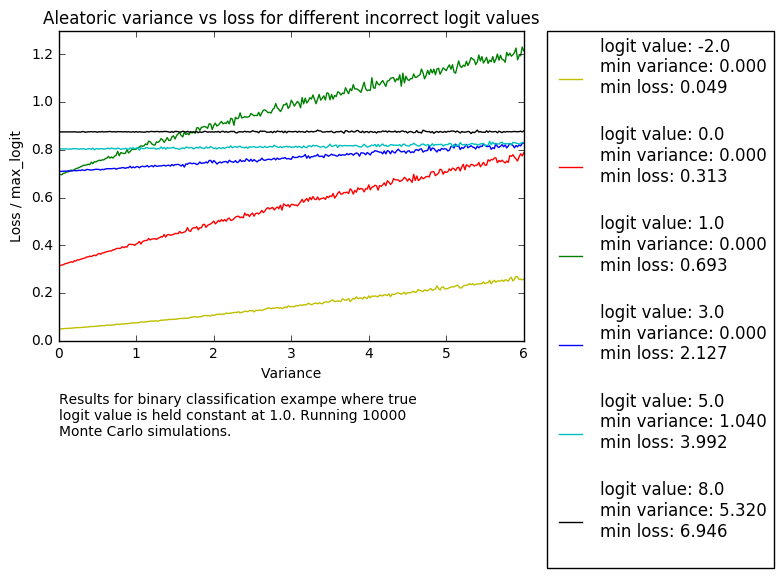

In [9]:
def plot_variance_loss(idxs):
  colors = ['y', 'r', 'g', 'b', 'c', 'k']
  lines = []
  losses = []
  for i in range(len(idxs)):
    idx = idxs[i]
    min_var_idx = np.argmin(Z[:,idx])
    min_var = Y[min_var_idx,idx]
    min_loss = Z[min_var_idx,idx]
    loss = Z[:,idx]/max(X[0,idx], 1.0)
    losses.append(loss)
    legend_label = 'logit value: {0:}\nmin variance: {1:.3f}\nmin loss: {2:.3f}\n'.format(X[0,idx], min_var, min_loss)
    line, = plt.plot(Y[:,idx], loss, colors[i], label=legend_label)
    lines.append(line)
    
  plt.xlabel('Variance')
  plt.ylabel('Loss / max_logit')
  plt.axis([0, 6, 0.0, 1.3])
  plt.legend(handles=lines, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.title('Aleatoric variance vs loss for different incorrect logit values')
  plt.text(0, -.4, 'Results for binary classification exampe where true\nlogit value is held constant at 1.0. Running 10000\nMonte Carlo simulations.')
  plt.savefig('blog_images/aleatoric_variance_loss_function_analysis', bbox_inches='tight')
  plt.show()

plot_variance_loss([0, 4, 6, 10, 14, 20])

